In [16]:
import context
from Integrator_Functions import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from Additional_Functions import create_interp_T, create_interp_solar, create_interp_albedo, temp_ave, create_clouds
import matplotlib.pyplot as contourf
from scipy import interpolate
import time

## Simple Model

In [47]:
class Integ71(Integrator):
    def set_yinit(self):

        ## Set up the latitude array:
        latitudes = np.arange(0, 91, 1)
            
        # Set up the needed constants for the derivation
        solar_arr = create_interp_solar(latitudes)
        albedo_arr = create_interp_albedo(latitudes)
        constants = namedtuple('constants', ['solar', 'albedo'])
        self.initvars = constants(solar_arr, albedo_arr)

        ## Set up the initial temperature array
        interp_temp = create_interp_T(latitudes)
        self.yinit = interp_temp

        # Set the integrator to array of length 91
        self.nvars = 91
        return None

    def __init__(self, coeffFileName):
        super().__init__(coeffFileName)
        self.set_yinit()

    def derivs5(self, y, t):
        """arrs.solar=solar insolation
           arrs.albedo=albedo


           returns dT/dt
        """
        ## derivtive is dT/dt = (1/cp)*[(1-arrs.albedo)*arrs.solar - A - B*Temp - F*(Temp-Tavg)]
        As = 315
        Bs = 4.6
        cp = 2.08e8
        F = 3.8
        # F = 0
        Tavg = temp_ave(y)
        Temp = y
        arrs = self.initvars
        f = (1/cp)*((1-arrs.albedo)*arrs.solar - As - Bs*Temp - F*(Temp-Tavg))
        return f
     

In [48]:
theSolver = Integ71('init_conds_simple.yaml')
timeVals, yVals, errorList = theSolver.timeloop5Err()

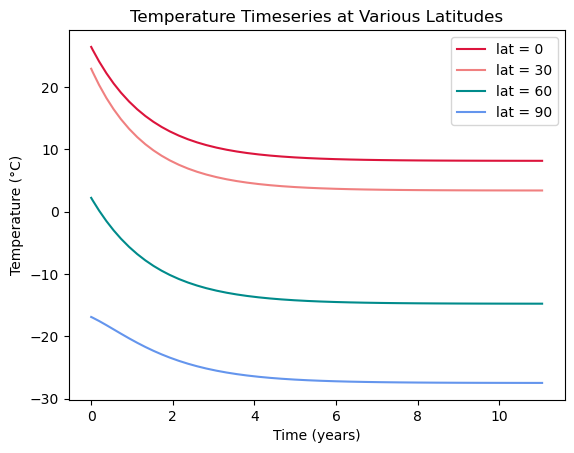

In [50]:
plt.plot(timeVals/60/60/24/365,yVals[:,0], label = 'lat = 0', c = 'crimson')
plt.plot(timeVals/60/60/24/365,yVals[:,30], label = 'lat = 30', c = 'lightcoral')
plt.plot(timeVals/60/60/24/365,yVals[:,60], label = 'lat = 60', c = 'darkcyan')
plt.plot(timeVals/60/60/24/365,yVals[:,90], label = 'lat = 90', c = 'cornflowerblue')

plt.title('Temperature Timeseries at Various Latitudes')
plt.xlabel('Time (years)')
plt.ylabel('Temperature (°C)')
plt.legend()
#set f to zero to justify behaviour 
# run with fixed and adaptive to compare solutions

When we run the simple model with our given initial conditions, we find that a steady state is reached after approximately five years and this equilibrium temperature is cooler than the initial temperature at every latitude. 

(0.0, 90.0)

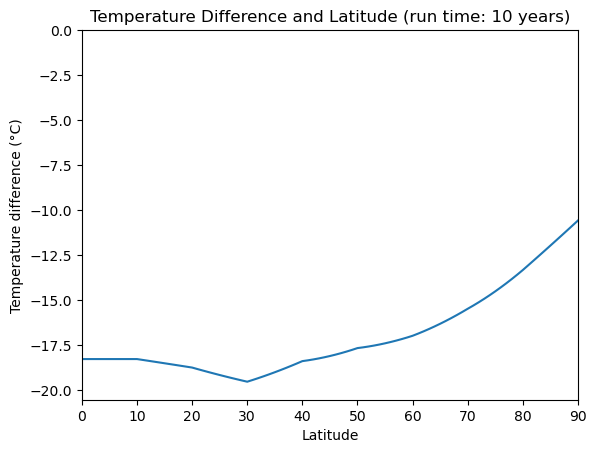

In [10]:
lat = np.linspace(0,90,91)
initial = yVals[0]
end = yVals[-1]
plt.plot(lat, end-initial)
plt.ylabel('Temperature difference (°C)')
plt.xlabel('Latitude')
plt.title('Temperature Difference and Latitude (run time: 10 years)')
plt.ylim(min(end-initial)-1, 0)
plt.xlim(0,90)

From this plot, we can see that the largest temperature decrease occurs from 0-30 degrees latitude with a minimua occuring at 30 degrees latitude. The temperature does not decrease quite as much at the poles. Why is it like this?

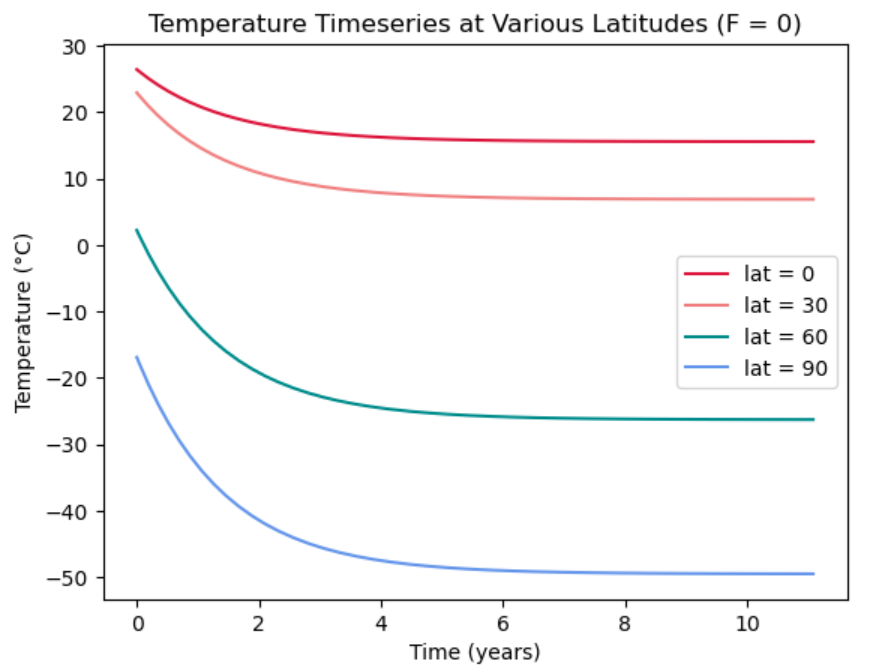

In this figure, the heat advection constant is zero. We could expect that since the equator has the largest solar constant term and the smallest albedo, the temperature decrease should be smaller in magnitude than it was previously. Since the heat is not being transported form the equator to the poles, we would expect the magnitude of the temperature decrease to be larger than it was previously. There would be a larger temperature gradient between the equator and the poles.

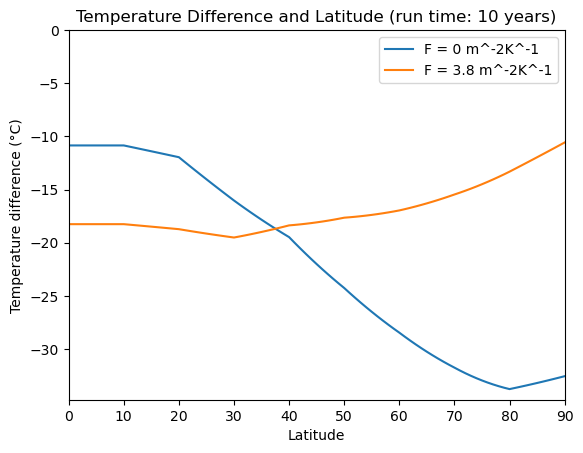

In [14]:
theSolver = Integ71('init_conds_simple.yaml')
timeValsF, yValsF, errorListF = theSolver.timeloop5Err()

lat = np.linspace(0,90,91)
initialF = yValsF[0]
endF = yValsF[-1]
plt.plot(lat, endF-initialF, label = 'F = 0 m^-2K^-1')
plt.plot(lat, end-initial, label = 'F = 3.8 m^-2K^-1')
plt.ylabel('Temperature difference (°C)')
plt.xlabel('Latitude')
plt.title('Temperature Difference and Latitude (run time: 10 years)')
plt.ylim(min(endF-initialF)-1, 0)
plt.xlim(0,90)
plt.legend()

Text(0.5, 1.0, 'Weighted Temperature Averages Plotted Against Each Other')

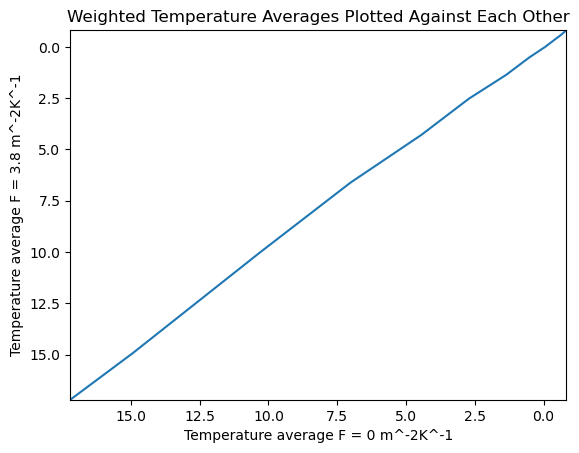

In [35]:
def temp_ave(T):
    """
    input: temperature distribution array in Kelvin from previous timestep and latitude array in degrees      (both of length 91)
    output: average temperature accross the globe in Kelvin (float)
    """
    lat = np.arange(0, 91, 1)
    deg2rad = np.pi/180
    
    denominator = np.sum(np.cos(lat*deg2rad))
    numerator = np.sum(T * np.cos(lat*deg2rad))
    
    Tave = numerator / denominator
    
    return Tave

ave_f0 = []
ave_f38 = []
for i in range(len(yValsF[:,0])):
    Tave_F0 = temp_ave(yValsF[i])
    Tave_F38 = temp_ave(yVals[i])

    ave_f0.append(Tave_F0)
    ave_f38.append(Tave_F38)
    # print(Tave_F0, Tave_F38, Tave_F0 == Tave_F38)

plt.plot(ave_f0, ave_f38)
plt.xlim(max(ave_f0), min(ave_f0))
plt.ylim(max(ave_f38), min(ave_f38))
plt.ylabel('Temperature average F = 3.8 m^-2K^-1')
plt.xlabel('Temperature average F = 0 m^-2K^-1')
plt.title('Weighted Temperature Averages Plotted Against Each Other')

Text(0.5, 1.0, 'Temperature at Various Latitudes')

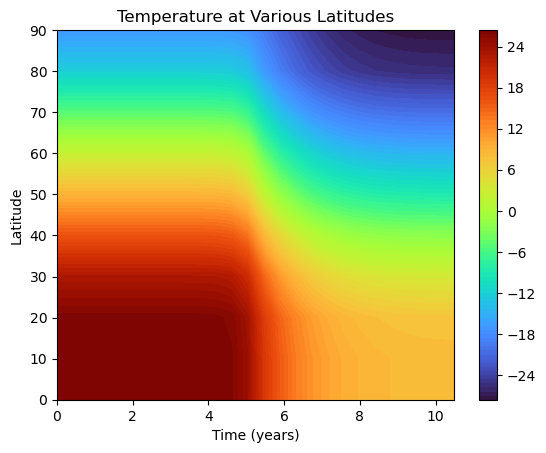

In [12]:
lat = np.linspace(0,90,91)
time = np.linspace(0,timeVals[-1]/60/60/24/365, len(yVals[:,0]))

X, Y = np.meshgrid(time,lat)
N = 91
cs = plt.contourf(X, Y, np.transpose(yVals), N, cmap = 'turbo')
cbar = plt.colorbar(cs) 
plt.xlabel('Time (years)')
plt.ylabel('Latitude')
plt.title('Temperature at Various Latitudes')